# Comparison of BootComp against OBCA-m on single objective problems

This notebook reruns some of the analysis published with OBCA-m, using common random numbers (CRN) and the BootComp algorithm.

All problems are single objective with no chance constraints.

* The first problem has 10 system designs with a constant variance.  That task is to return the top 3 (largest) systems.

* The second problem is taken from the Law inventory problem, but is adapted to operate with common random numbers
---

# **Parameter to help reproducibility test**
This version of the notebook has been modified to help with reproducing the results reporting in the paper.

> Advice: the parameter `N_EXPERIMENTS` controls the total number of times that the analysis is repeated.  Runtimes can take several hours for large values. It is recommended that a small number is tested initially (e.g. 10) to ensure that notebook runs all the way through without crashing and wasting computation time. 

In [ ]:
#in the paper we ran 10,000 experiments.
N_EXPERIMENTS = 10_000

---

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit


As all problems used in the comparison do not have chance constraints then only the `quality_bootstrap()` function is needed

In [3]:
from bootcomp.bootstrap import quality_bootstrap

## Functions for creating the data used in the experiments

In [4]:
#@jit(nopython=True)
def bootstrap(data, boots=1000, random_state=None):
    """
    Returns a numpy array containing the bootstrap resamples
    Useful for creating a large number of experimental datasets 
    for testing R&S routines
    
    Keyword arguments:
    data -- numpy.ndarray of systems to boostrap
    boots -- integer number of bootstraps (default = 1000)
    random_state -- int, set the numpy random number generator
    """
    
    np.random.seed(random_state)
    experiments = boots
    designs = 10
    samples = data.shape[1]
     
    datasets = np.zeros((experiments, designs, samples))
     
    for exp in range(experiments):
        
        for design in range(designs):

            for i in range(samples):

                datasets[exp][design][i] = data[design][round(np.random.uniform(0, samples)-1)]
      
    return datasets

In [5]:
#@jit(nopython=True)
def crn_bootstrap(data, boots=1000, random_state=None):
    """
    Returns a numpy array containing the bootstrap resamples
    Useful for creating a large number of experimental datasets 
    for testing R&S routines.  This function assumes common
    random numbers have been used to create the original data.
    
    Keyword arguments
    data -- numpy.ndarray of systems to boostrap
    boots -- integer number of bootstraps (default = 1000)
    random_state -- int, set the numpy random number generator
    """
    
    np.random.seed(random_state)

    experiments = boots
    designs = data.shape[0]
    samples = data.shape[1]
    
    datasets = np.zeros((experiments, designs, samples))
     
    for exp in range(experiments):
        
         for i in range(samples):

                row = data.T[np.random.choice(data.shape[0])]
                
                for design in range(designs):
                    datasets[exp][design][i] = row[design]  
      
    return datasets

#### Use the following code to create independent samples

In [6]:
def experiments_independent_samples(ifile_name, boots=1000, random_state=None):
    data = np.genfromtxt(ifile_name, delimiter=",", skip_footer=0).transpose()
    experiments = bootstrap(data, boots=boots, random_state=random_state)
    return experiments

#### Use the following code to create CRN data sets

In [7]:
def experiments_dependent_samples(ifile_name, boots=1000, random_state=None):
    data = np.genfromtxt(ifile_name, delimiter=",", skip_footer=0).transpose()
    experiments = crn_bootstrap(data, boots=boots, random_state=random_state)
    return experiments

## BootComp Experiments

In [8]:
def simulate_experiment(model, reps, systems):
    return model[:,:reps][systems]

In [9]:
def cs(selected_top_m, true_top_m):
    """Returns boolean value:
    True = correct selection of top m
    False = incorrect selection (one or more of selected top m is incorrect)
    
    Keyword arguments:
    
    selected_top_m --   numpy.array containing the indexes of 
                        the top m means selected by the algorithm
                        
    true_top_m --       numpy.array containing the indexes of 
                        the true top m means
    
    """
    return np.array_equal(np.sort(selected_top_m), true_top_m)

In [10]:
def get_budgets(max_t, min_t, increment_t):
    #incremental budgets 200, 400, .... T
    budgets = [i for i in range(min_t, max_t + increment_t, increment_t)]
    return budgets

In [11]:
def simulate_stage(model, design_indexes, reps, x, y, boots, opt='max'):
    
        
    output_data = simulate_experiment(model=model, 
                                      reps=reps, 
                                      systems=design_indexes)
    
    if opt == 'max':
        best_design_index_sub = output_data.mean(axis=1).argmax()
    else:
        best_design_index_sub = output_data.mean(axis=1).argmin()
    
    best_design_index = design_indexes[best_design_index_sub]
    
    df_output = pd.DataFrame(output_data).T
    df_output.columns = design_indexes 
    
    results = quality_bootstrap(df_output, 
                                design_indexes, 
                                best_design_index, 
                                x, y, boots, cores='p')

    return results

In [12]:
def bootcomp(model, budget, m, n_0, boots, x1, y1, x2, y2, opt='max'):

    #stage 1
    #simulate n reps from all system designs
    k = model.shape[0]
    design_indexes = [i for i in range(k)]

    stage_one_results = simulate_stage(model, design_indexes,
                                      reps=n_0, x=x1, y=y1, boots=boots,
                                      opt=opt)
       
    
    #stage 2
    #equal allocation of remaining budget
    stage_two_reps = int((budget - (n_0 * k))/len(stage_one_results)) + n_0
       
    design_indexes = (stage_one_results).tolist()
        
    stage_two_results = simulate_stage(model, design_indexes,
                                       reps=stage_two_reps, 
                                       x=x2, y=y1, boots=boots,
                                       opt=opt)

    return stage_two_results.tolist(), stage_two_reps

In [13]:
def bootcomp_top_m(model, reps, design_indexes, m, opt='max'):
    
    output_data = simulate_experiment(model=model, 
                                      reps=reps, 
                                      systems=design_indexes)
    
    sorted_indexes = output_data.mean(axis=1).argsort()
    
    if opt == 'max':
        x = sorted_indexes[-m:]
        best_design_indexes = np.array(design_indexes)[x] 
        
        
    else:
        x = sorted_indexes[:m]
        best_design_indexes = np.array(design_indexes)[x] 
        
    return best_design_indexes
        
    

In [14]:
def numerical_experiment(experiments, budgets, m, n_0, true_top_m, 
                         x1, y1, x2, y2, nboots=1000, opt='max'):
    """
    Conduct a user set number of numerical experiments on the algorithm
    for different computational budgets
    
    Returns:
    1. numpy.ndarray containing P{cs} for each budget
        
    Keyword arguments:
    experiments -- numpy.ndarray[experiments][designs][replication]
    budgets -- python list containing budgets
    model_file -- string path to model 
    
    """
    n_experiments = experiments.shape[0]
    k = experiments.shape[1]  
    
    correct_selections = np.zeros((n_experiments, len(budgets)))
   
    for exp in range(n_experiments):

        for t in range(len(budgets)):

            selected_top_m, reps = bootcomp(budget=budgets[t],
                                            model=experiments[exp],
                                            m=m, 
                                            n_0=n_0, 
                                            boots=nboots, x1=x1, y1=y1,
                                            x2=x2, y2=y2, opt=opt)
            
            
            #BootComp can return > m solutions.  This function trims to top m 
            top_m = bootcomp_top_m(experiments[exp], reps, selected_top_m, m, opt)
            
            #is it the correct selection?
            correct_selections[exp][t] = cs(top_m, true_top_m)
                        
    return correct_selections
    

## Tests 1: Top 3 systems from 10

In this example we simulate 10,000 experiments of 10 competing system designs.  Each design has equal variance.  BootComp must return the 3 designs with the largest mean.

**Ten Designs with CRN**

Both OCBA-m and BootComp were run with 20 initial replications for each design ($n_{1}=20)$. In all of the experiments we use the following values for the BootComp parameters $\alpha_1 = 0.2, \alpha_2= 0.05, \beta_1= 0.6, \beta_2 = 0.3$. 

We tested budgets between 300 and 2000 and found that when competing designs use perfectly synchronized CRN, BootComp correctly selected the top three designs in all 10,000 experiments for each budget.

In [15]:
def experiment_1():
    T = 3000
    increment_t = 100
    min_budget = 300
    n_0 = 20
    
    #############################################################
    #set to 10 to avoid long runtime - set to 10000 to match paper
    n_experiments = N_EXPERIMENTS
    ############################################################
    #note beta_1 can be more restrictive e.g. 0.4 for CRN experiments
    #but we use 0.6 so that it is the same as no CRN experiments which are
    #more challenging for bootcomp and OCBA-m.
    x1 = 0.6 
    y1 = 0.8 # 1 - alpha
    x2 = 0.3 
    y2 = 0.95 # 1-alpha
    boots=1000
    m = 3
    seed = 42

    #specific to this implementation
    ifile_name = 'data/EG1a_CRN.csv'
    reps_available = 10000

    #info for correct selection
    true_top_m = np.array([7, 8, 9])

    #incremental budgets 200, 400, .... T
    budgets = get_budgets(T, min_budget, increment_t)
    
    #the below is some short cut code to help produce the figures in the
    #paper - comment these out to get a full range of results (with 
    #assciated longer runtime!)
    budgets = [600, 1400, 2000, 3000, 5000]
    
    #generate experimental dataset
    experiments = experiments_dependent_samples(ifile_name, 
                                                boots=n_experiments,
                                                random_state=seed)
    
    #run numerical experiment
    css = numerical_experiment(experiments, 
                               budgets, 
                               m,
                               n_0,
                               true_top_m, 
                               x1, y1, x2, y2, boots)
    return css

**Ten designs with no CRN.**

Both OCBA-m and BootComp were run with 20 initial replications for each design ($n_{1}=20)$. In all of the experiments we use the following values for the BootComp parameters $\alpha_1 = 0.2, \alpha_2= 0.05, \beta_1= 0.6, \beta_2 = 0.3$. Again using 10,000 experiments, we tested budgets of between 600 and 5000 replications.

* experiment 1a: $\alpha_1$ = 0.2
* experiment 1b  $\alpha_1$ = 0.3 (used to create figure 2 in paper)


In [16]:
def experiment_1a_No_CRN():
    T = 8000
    increment_t = 100
    min_budget = 8000
    n_0 = 20
    
    #############################################################
    #set to 10 to avoid long runtime - set to 10000 to match paper
    n_experiments = N_EXPERIMENTS
    ############################################################
    
    x1 = 0.6 
    y1 = 0.8 # 1 - alpha
    x2 = 0.3
    y2 = 0.95 # 1 - alpha
    boots= 1000
    m = 3
    seed = 101

    #specific to this implementation
    ifile_name = 'data/EG1a.csv'
    reps_available = 10000

    #info for correct selection
    true_top_m = np.array([7, 8, 9])

    #incremental budgets 200, 400, .... T
    budgets = get_budgets(T, min_budget, increment_t)
    
    #the below is some short cut code to help produce the figures in the
    #paper - comment these out to get a full range of results (with 
    #assciated longer runtime!)
    budgets = [600, 1400, 2000, 3000, 5000]
        
    #generate experimental dataset - independent samples!
    experiments = experiments_independent_samples(ifile_name, 
                                                  boots=n_experiments,
                                                  random_state=seed)
    
    #run numerical experiment
    css = numerical_experiment(experiments, 
                               budgets, 
                               m,
                               n_0,
                               true_top_m, 
                               x1, y1, x2, y2, boots)
    return css

In [45]:
def experiment_1b_No_CRN():
    T = 8000
    increment_t = 100
    min_budget = 8000
    n_0 = 20
    
    #############################################################
    #set to 10 to avoid long runtime - set to 10000 to match paper
    n_experiments = N_EXPERIMENTS
    ############################################################
    
    x1 = 0.6
    y1 = 0.7 #1 - alpha
    x2 = 0.3
    y2 = 0.95 # 1 - alpha
    boots= 1000
    m = 3
    seed = 101

    #specific to this implementation
    ifile_name = 'data/EG1a.csv'
    reps_available = 10000

    #info for correct selection
    true_top_m = np.array([7, 8, 9])

    #incremental budgets 200, 400, .... T
    budgets = get_budgets(T, min_budget, increment_t)
    
    #the below is some short cut code to help produce the figures in the
    #paper - comment these out to get a full range of results (with 
    #assciated longer runtime!)
    budgets = [600, 1400, 2000, 3000, 5000]
        
    #generate experimental dataset - independent samples!
    experiments = experiments_independent_samples(ifile_name, 
                                                  boots=n_experiments,
                                                  random_state=seed)
    
    #run numerical experiment
    css = numerical_experiment(experiments, 
                               budgets, 
                               m,
                               n_0,
                               true_top_m, 
                               x1, y1, x2, y2, boots)
    return css

## Tests 2: Law Inventory Example

In this example, we simulate 10,000 experiments of 9 competing system designs in the Law inventory problem. Common random numbers have been employed achieveing ~89% variance reduction. BootComp must return the 3 designs with the largest mean.

### Maximisation Test (top 3)

In [18]:
def experiment_2():
    T = 500
    increment_t = 100
    min_budget = 300
    n_0 = 20
    #############################################################
    #set to 10 to avoid long runtime - set to 10000 to match paper
    n_experiments = N_EXPERIMENTS
    ############################################################
    x1 = 0.6
    y1 = 0.8
    x2 = 0.2
    y2 = 0.95
    boots = 1000
    m = 3
    seed = 42

    #specific to this implementation
    ifile_name = 'data/EGLaw_CRN.csv'
   
    #info for correct selection
    true_top_m = np.array([6, 7, 8])

    #incremental budgets 200, 400, .... T
    budgets = get_budgets(T, min_budget, increment_t)
    
    #generate experimental dataset
    experiments = experiments_dependent_samples(ifile_name, 
                                                boots=n_experiments,
                                                random_state=seed)
    
    #run numerical experiment
    css = numerical_experiment(experiments, 
                               budgets, 
                               m,
                               n_0,
                               true_top_m, 
                               x1, y1, x2, y2, boots)
    return css

## Minimisation example (top 2) 

In [19]:
def experiment_3():
    T = 1000
    increment_t = 100
    min_budget = 300
    n_0 = 20
    ##############################################################
    #set to 10 to avoid long runtime - set to 10000 to match paper
    n_experiments = N_EXPERIMENTS
    ##############################################################
    x1 = 0.1
    y1 = 0.95
    x2 = 0.05
    y2 = 0.95
    boots=1000
    m = 2
    opt = 'min'
    seed = 42
    
    #specific to this implementation
    ifile_name = 'data/EGLaw_CRN.csv'
   
    #info for correct selection
    true_top_m = np.array([1, 2])

    #incremental budgets 200, 400, .... T
    budgets = get_budgets(T, min_budget, increment_t)
    
    #generate experimental dataset
    experiments = experiments_dependent_samples(ifile_name, 
                                                boots=n_experiments,
                                                random_state=seed)
    
    #run numerical experiment
    css = numerical_experiment(experiments, 
                               budgets, 
                               m,
                               n_0,
                               true_top_m, 
                               x1, y1, x2, y2, boots, opt=opt)
    return css

## Run Experiments

Note: If running a large number of experiments (e.g. 10,000) against a large number of budgets (e.g. 30) then expect runtimes of around 4-5 hours.

**OBCA-m dataset: k = 10, var=const, m=3, type=maximisation**

In [20]:
results1 = experiment_1()

In [21]:
results1.shape

(10000, 5)

In [22]:
pd.DataFrame(results1).head()

,0,1,2,3,4
0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0


**OBCA-m dataset: k = 10, var=const, m=3, type=maximisation, CRN=False; alpha=0.2**

In [23]:
results1a = experiment_1a_No_CRN()
results1a.shape

(10000, 5)

**OBCA-m dataset: k = 10, var=const, m=3, type=maximisation, CRN=False; alpha=0.3**

In [46]:
results1b = experiment_1b_No_CRN()
results1b.shape

(10000, 5)

**Law Inventory example. k = 9, m=3, type=maximisation**

In [25]:
results_law_max = experiment_2()

In [26]:
results_law_max.shape

(10000, 3)

**Law Inventory example. k = 9, m=2, type=minimisation** 

In [27]:
results_law_min = experiment_3()

In [28]:
results_law_min.shape

(10000, 8)

# Summary of experimental results.

In [29]:
def format_results(df_results, budgets):
    '''
    Format experimental results in a table
    summarising PCS
    
    Params:
    ------
    df_results: pd.DataFrame
        Experimentation results.  (N_EXPERIMENTS, len(budgets))
        
    budget: array-like
        list of replication budgets.
        
    '''
    budgets = pd.DataFrame(budgets, columns=['budget'])
    count = pd.DataFrame(df_results).sum()
    pcs = pd.DataFrame(df_results).mean()
    pcs.name = 'pcs'
    count.name = 'n'
    pcs = pd.concat([budgets, count, pcs], axis=1)
    return pcs
    

## Section 4.4.1 in paper.  OCBA-m dataset - 10 systems. CRN

**OBCA-m dataset: k = 10, var=const, m=3, type=maximisation. CRN=True**

We tested budgets between 300 and 2000 and found that when competing designs use perfectly synchronized CRN, BootComp correctly selected the top three designs in all 10,000 experiments for each budget.

In [30]:
budgets = [600, 1400, 2000, 3000, 5000]
pcs_1 = format_results(results1, budgets)
pcs_1

,budget,n,pcs
0,600,10000.0,1.0
1,1400,10000.0,1.0
2,2000,10000.0,1.0
3,3000,10000.0,1.0
4,5000,10000.0,1.0


## Section 4.1.2 in paper. OCBA-m dataset - 10 systems Independent samples

**OBCA-m dataset: k = 10, var=const, m=3, type=maximisation, CRN=False; beta1=0.3** 

The results illustrate the importance of CRN in variance reduction and, as expected, BootComp loses its advantage over OCBA-m in examples where samples are independent. Without CRN, BootComp was unable to match OCBA-m under any of the budget assumptions we included. This is not unexpected as OCBA-m is a sequential algorithm and BootComp includes only two stages. 

In [31]:
budgets = [600, 1400, 2000, 3000, 5000]
pcs_1a = format_results(results1a, budgets)
pcs_1a

,budget,n,pcs
0,600,6149.0,0.6149
1,1400,8398.0,0.8398
2,2000,8987.0,0.8987
3,3000,9411.0,0.9411
4,5000,9559.0,0.9559


In [72]:
#export results for fig2
pcs_1a.to_csv('./results/figure2_bootcomp_data.csv')

In [47]:
budgets = [600, 1400, 2000, 3000, 5000]
pcs_1b = format_results(results1b, budgets)
pcs_1b

,budget,n,pcs
0,600,6576.0,0.6576
1,1400,8736.0,0.8736
2,2000,9272.0,0.9272
3,3000,9601.0,0.9601
4,5000,9734.0,0.9734


In [73]:
#export results for fig2
pcs_1a.to_csv('./results/figure2_bootcomp_data2.csv')

In [70]:
def plot_experiment1(pcs_1a, pcs_1b, budgets):
    '''
    Basic plot of the results.
    '''
    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    ax.plot(budgets, pcs_1a['pcs'],linewidth=3, marker='s', 
            linestyle='',  markersize=6)
    ax.plot(budgets, pcs_1b['pcs'],linewidth=3, marker='^', 
            linestyle='',  markersize=6)
    ax.set_xlabel('Replication Budget')
    ax.set_ylabel('P(CS)')

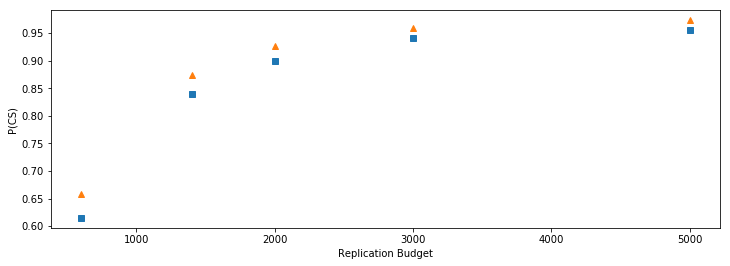

In [71]:
plot_experiment1(pcs_1a, pcs_1b, budgets)

# Section 4.1.3 in paper: Experiments for Law Inventory example

In the inventory example, full synchronization has not been achieved, but CRN has still induced a high positive correlation across the nine designs. Both OCBA-m and BootComp select the top three designs (highest mean) in all 10,000 experiments for each budget.

## Experiment 2: Law Inventory example (maximisation)

In [33]:
T = 500
increment_t = 100
min_budget = 300

budgets = get_budgets(T, min_budget, increment_t)
pcs_2 =  format_results(results_law_max, budgets)
pcs_2

,budget,n,pcs
0,300,10000.0,1.0
1,400,10000.0,1.0
2,500,10000.0,1.0


## Experiment 3: Law Inventory minimisation example

This result held when the problem was changed into a minimization to select the smallest two designs.

In [34]:
T = 1000
increment_t = 100
min_budget = 300

budgets = get_budgets(T, min_budget, increment_t)
pcs_3 =  format_results(results_law_min, budgets)
pcs_3

,budget,n,pcs
0,300,10000.0,1.0
1,400,10000.0,1.0
2,500,10000.0,1.0
3,600,10000.0,1.0
4,700,10000.0,1.0
5,800,10000.0,1.0
6,900,10000.0,1.0
7,1000,10000.0,1.0
